In [52]:
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict
from reliability_diagrams import *

In [88]:
df

,confidence,true_label,pred_label
0,0.008,0.0,1
1,0.000,0.0,1
2,0.866,1.0,1
3,0.024,0.0,1
4,0.002,0.0,1
...,...,...,...
9995,0.010,0.0,1
9996,0.000,0.0,1
9997,0.008,0.0,1
9998,0.754,1.0,1


In [87]:
df = pd.read_csv('calibration_data.csv')
plot_name = 'calibration_data'
df['pred_label'] = 1
y_true = df.true_label.values
y_pred = df.pred_label.values
y_conf = df.confidence.values

In [73]:
# Override matplotlib default styling.
# plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

In [74]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins

    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.

    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.

    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float64)
    bin_confidences = np.zeros(num_bins, dtype=np.float64)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

In [75]:
def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.

    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.

    The black line is the accuracy, the other end of the bar is the confidence.

    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.

    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.

    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.

    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


In [76]:
def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig

In [77]:
def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


In [78]:

def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])

C:\Users\peter\AppData\Local\Temp\ipykernel_7152\1827701276.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


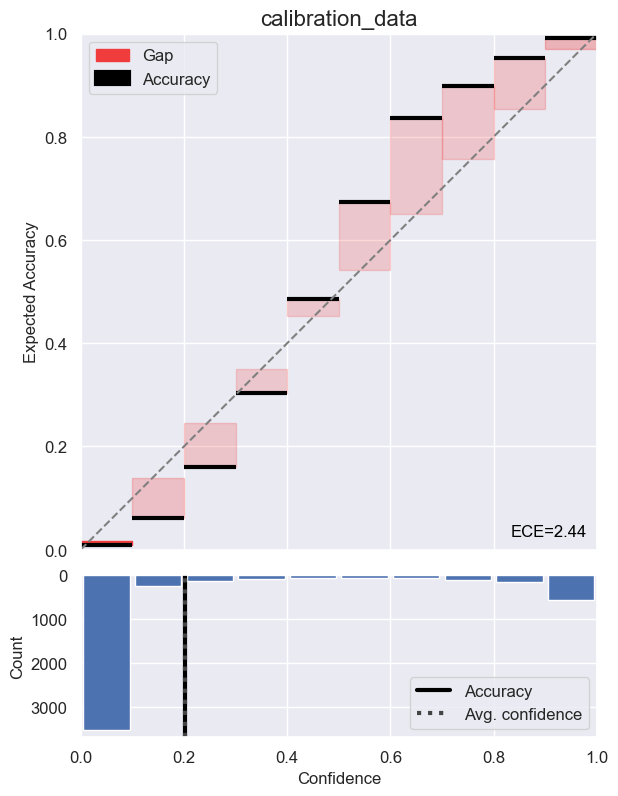

In [89]:
title = "\n".join(plot_name.split())

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)